# Importing the UK's Airspaces

We import data on the UK's ATC regions from the UK NATS and extract the useful information including the shape of each region.

## Setup

Modify the URL below to point to the latest version of the UK's AIP.

In [1]:
dataset_location = 'https://www.aurora.nats.co.uk/htmlAIP/Publications/2020-06-18-AIRAC/html/eAIP/EG-ENR-2.1-en-GB.html#ENR-2.1'

In [2]:
import requests
from datetime import datetime, timezone
import time
import numpy as np
import pandas as pd
import descartes, geopandas
import cartopy
from shapely.geometry import LineString, Point, Polygon, MultiPolygon, base
import pyproj
from shapely.ops import transform, unary_union
import re
import math
import matplotlib.pyplot as plt

from rtree import index # requires spatialindex_devel

import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature

from traffic.data import opensky
from traffic.core import Airspace
from traffic.core.airspace import ExtrudedPolygon

import networkx as nx
import holoviews as hv
import hvplot.networkx as hvnx

In [3]:
namestring = r"^(?P<name>.+  )(?P<lateral_limits>Same extent as .+|( ?-?\d{6}(N|S) \d{7}(E|W)( \(.*\))?| ?thence (anti-)?clockwise by the arc of a circle radius \d+(.\d+)? NM centred on -?\d{6}(N|S) \d{7}(E|W) to)+( but excluding .*)?)  ?(Upper limit: (?P<upper_limit>FL\d+|\d+ FT (ALT|SFC)))  ?(Lower limit: (?P<lower_limit>FL\d+|\d+ FT (ALT|SFC)|SFC))  ?(Class: (?P<class>[A-G]))(?P<second>  ?(Upper limit: (?P<upper_limit_2>FL\d+|\d+ FT (ALT|SFC)))  ?(Lower limit: (?P<lower_limit_2>FL\d+|\d+ FT (ALT|SFC)|SFC))  ?(Class: (?P<class_2>[A-G])))?$"
callsignstring = r"^((?P<callsign>[A-Z ]+)  )?((?P<language>English)?(  )?)(?!English)(?P<hours>.*)$"
freqstring = r"^(?P<frequency>\d{3}\.\d{3})(  (?P<purpose>.*))?$"
lateralstring = r"((?P<edge1>Same extent as .+)| ?-?(?P<point>(?P<point_lat>\d{6})(?P<point_ns>(N|S)) (?P<point_long>\d{7})(?P<point_ew>(E|W)))| ?(?P<circle>thence (?P<circle_anti>(anti-)?)clockwise by the arc of a circle radius (?P<circle_radius>\d+(.\d+)?) NM centred on -?(?P<circle_lat>\d{6})(?P<circle_ns>(N|S)) (?P<circle_long>\d{7})(?P<circle_ew>(E|W)) to ?-?((?P<circle_lat2>\d{6})(?P<circle_ns2>(N|S)) (?P<circle_long2>\d{7})(?P<circle_ew2>(E|W))))|(?P<edge2> but excluding the .*))"
verticalstring = r"^((?P<fl>FL(?P<fl_num>\d+))|(?P<ft>(?P<ft_num>\d+) FT (?P<ft_alt_sfc>ALT|SFC))|(?P<sfc>SFC))$"

expression_namestring = re.compile(namestring)
expression_callsignstring = re.compile(callsignstring)
expression_freqstring = re.compile(freqstring)
expression_lateral = re.compile(lateralstring)
expression_vertical = re.compile(verticalstring)

## Initial Data Processing

We parse the HTML table using a built-in pandas method and parse each row with a series of regular expressions to extract the data in a useful format.

In [4]:
dfs = pd.read_html(dataset_location, flavor='bs4')

df = dfs[0].fillna(method='ffill')

In [5]:
def process_row(row):
    name_long = row[0]
    unit = row[1]
    callsign_long = row[2]
    freq_long = row[3]
    remarks = row[4]
    name_processed = process_namestring(name_long)
    callsign_processed = process_callsignstring(callsign_long)
    freq_processed = process_freqstring(freq_long)
    return [
        name_processed.get('name'),
        name_processed.get('lateral_limits'),
        name_processed.get('upper_limit'),
        name_processed.get('lower_limit'),
        name_processed.get('class_of_airspace'),
        name_processed.get('upper_limit_2'),
        name_processed.get('lower_limit_2'),
        name_processed.get('class_of_airspace_2'),
        unit,
        callsign_processed.get('callsign'),
        callsign_processed.get('language'),
        callsign_processed.get('hours'),
        freq_processed.get('frequency'),
        freq_processed.get('purpose'),
        remarks
    ]

def process_vertical_limit(string):
    match = expression_vertical.match(string)
    if match is not None:
        if match.group('fl') is not None:
            return int(match.group('fl_num')) * 100
        elif match.group('ft') is not None:
            return int(match.group('ft_num'))
        elif match.group('sfc') is not None:
            return 0
        else:
            raise Exception(string)
    else:
        raise Exception(string)

def process_namestring(string):
    match = expression_namestring.match(string)
    if match is not None:
        ret = dict()
        ret['original'] = match.group(0)
        ret['name'] = match.group('name').strip()
        ret['lateral_limits'] = match.group('lateral_limits')
        ret['upper_limit'] = process_vertical_limit(match.group('upper_limit'))
        ret['lower_limit'] = process_vertical_limit(match.group('lower_limit'))
        ret['class_of_airspace'] = match.group('class')
        ret['second'] = match.group('second') is not None
        if ret['second']: # second upper/lower limit and class
            ret['upper_limit_2'] = process_vertical_limit(match.group('upper_limit_2'))
            ret['lower_limit_2'] = process_vertical_limit(match.group('lower_limit_2'))
            ret['class_of_airspace_2'] = match.group('class_2')
        return ret
    else:
        raise Exception(string)

def process_callsignstring(string):
    match = expression_callsignstring.match(string)
    if match is not None:
        ret = dict()
        ret['original'] = match.group(0)
        ret['callsign'] = match.group('callsign')
        ret['language'] = match.group('language')
        ret['hours'] = match.group('hours')
        return ret
    else:
        raise Exception(string)

def process_freqstring(string):
    match = expression_freqstring.match(string)
    if match is not None:
        ret = dict()
        ret['original'] = match.group(0)
        ret['frequency'] = match.group('frequency')
        ret['purpose'] = match.group('purpose')
        return ret
    else:
        raise Exception(string)


df2 = df.apply(process_row, axis=1, result_type='expand')

columns = [
    'name',
    'lateral_limits',
    'upper_limit',
    'lower_limit',
    'class_of_airspace',
    'upper_limit_2',
    'lower_limit_2',
    'class_of_airspace_2',
    'unit',
    'callsign',
    'language',
    'hours',
    'frequency',
    'purpose',
    'remarks'
]
df2.columns = columns

In [6]:
fir_index = (~df2.name.str.contains("FIR") & ~df2.name.str.contains("UIR")).idxmax()

In [7]:
fir = df2.head(fir_index).copy()
fir.head()

name                                     lateral_limits  upper_limit  \
0  LONDON FIR  550000N 0050000E -513000N 0020000E -510700N 00...        24500   
1  LONDON FIR  550000N 0050000E -513000N 0020000E -510700N 00...        24500   
2  LONDON FIR  550000N 0050000E -513000N 0020000E -510700N 00...        24500   
3  LONDON FIR  550000N 0050000E -513000N 0020000E -510700N 00...        24500   
4  LONDON FIR  550000N 0050000E -513000N 0020000E -510700N 00...        24500   

   lower_limit class_of_airspace  upper_limit_2  lower_limit_2  \
0        19500                 C        19500.0            0.0   
1        19500                 C        19500.0            0.0   
2        19500                 C        19500.0            0.0   
3        19500                 C        19500.0            0.0   
4        19500                 C        19500.0            0.0   

  class_of_airspace_2                       unit        callsign language  \
0                   G  LONDON CONTROL (SWANWICK)  LONDON CONTROL  English   
1                   G  LONDON CONTROL (SWANWICK)  LONDON CONTROL  English   
2                   G  LONDON CONTROL (SWANWICK)  LONDON CONTROL  English   
3                   G  LONDON CONTROL (SWANWICK)  LONDON CONTROL  English   
4                   G  LONDON CONTROL (SWANWICK)  LONDON CONTROL  English   

  hours frequency                                            purpose  \
0   H24   118.480                                               None   
1   H24   118.825  London TMA outbound radar: See London Terminal...   
2   H24   119.780  London TMA outbound radar: See London Terminal...   
3   H24   120.180                                               None   
4   H24   120.475                                               None   

                                             remarks  
0  LONDON CONTROL (SWANWICK):Note 1: The Le Touqu...  
1  LONDON CONTROL (SWANWICK):Note 1: The Le Touqu...  
2  LONDON CONTROL (SWANWICK):Note 1: The Le Touqu...  
3  LONDON CONTROL (SWANWICK):Note 1: The Le Touqu...  
4  LONDON CONTROL (SWANWICK):Note 1: The Le Touqu...

In [8]:
zones = df2.tail(-fir_index).copy()
zones.drop(['upper_limit_2', 'lower_limit_2', 'class_of_airspace_2'], axis=1, inplace=True)
zones.head()

name                                     lateral_limits  \
105  ABERDEEN CTA 1  572153N 0015835W -572100N 0015802W -572100N 00...   
106  ABERDEEN CTA 2  571522N 0015428W -570845N 0015019W thence cloc...   
107  ABERDEEN CTA 3  572100N 0023356W -570015N 0025056W -565433N 00...   
108      BALDER CTA  590504N 0013916E -581110N 0030955E -575615N 00...   
109       BANBA CTA  520049N 0060720W -514034N 0060027W -512400N 00...   

     upper_limit  lower_limit class_of_airspace           unit  \
105        11500         1500                 D  ABERDEEN/DYCE   
106        11500         1500                 D  ABERDEEN/DYCE   
107        11500         3000                 D  ABERDEEN/DYCE   
108         8500         1500                 D     NORWAY ACC   
109        66000        19500                 C    SHANNON ACC   

              callsign language                                         hours  \
105  ABERDEEN APPROACH  English                                                 
106  ABERDEEN APPROACH  English                                                 
107  ABERDEEN APPROACH  English                                                 
108     NORWAY CONTROL  English  0600 - 2030 Mon-Fri (1 hr earlier in summer)   
109    SHANNON CONTROL  English                                           H24   

    frequency               purpose  \
105   119.055  DOC 55 NM/25,000 FT.   
106   119.055  DOC 55 NM/25,000 FT.   
107   119.055  DOC 55 NM/25,000 FT.   
108   134.200                  None   
109   131.150                  None   

                                               remarks  
105  The Airspace remains notified even though the ...  
106  The Airspace remains notified even though the ...  
107  The Airspace remains notified even though the ...  
108             Mandatory carriage of ADS-B equipment.  
109  ATS within the BANBA CTA is delegated to Shann...

## Extracting Geographical Data

We take the text representation of each airspace's geometry and turn it into a geometry object that we can work with more easily.
We then use this to produce a geopandas GeoDataFrame.

Note: we are using buffer(0) to fix self-intersecting polygons. This turns "bow tie" shapes into a MultiPolygon.

TODO: fix curved sections, currently using resolution=1 because they don't quite work properly

In [9]:
def circle(start, end, centre, clockwise, resolution=10): # start, end, centre tuples (lat,long), clockwise bool
    # correct the centre by projecting it onto the perpendicular bisector of start and end (TODO better implementation)
    x1, y1 = start
    x2, y2 = end
    x3, y3 = centre
    # edge cases
    if y2 == y1:
        centre2 = ((x1 + x2) / 2, y3)
    elif x2 == x1:
        centre2 = (x3, (y1 + y2) / 2)
    else:
        m = (y2 - y1) / (x2 - x1)
        a = (((x1 + x2) / (2 * m)) + ((y1 + y2) / 2) + (m * x3) - y3) / (m + (1 / m))
        centre2 = (a, (m * (a - x3)) + y3)
    
    radius = math.sqrt(pow(start[0] - centre2[0], 2) + pow(start[1] - centre2[1], 2))
    angle1 = math.atan2(start[1] - centre2[1], start[0] - centre2[0])
    angle2 = math.atan2(end[1] - centre2[1], end[0] - centre2[0])
    
    step = (angle2 - angle1) / resolution
    if step > 0 and not clockwise:
        step = (-1) * ((2 * math.pi) - (angle2 - angle1)) / resolution
    if step < 0 and clockwise:
        step = ((2 * math.pi) + (angle2 - angle1)) / resolution
    
    ret = list()
    #ret.append(start)
    for i in range(1, resolution):
        angle = angle1 + i * step
        lat = centre2[0] + (radius * math.cos(angle))
        long = centre2[1] + (radius * math.sin(angle))
        ret.append((lat, long))
    ret.append(end)
    return ret

def strings_to_point(lat, ns, long, ew):
    latitude = int(lat) * (1 if ns == 'N' else -1) / 10000
    longitude = int(long) * (1 if ew == 'E' else -1) / 10000
    return (latitude, longitude)

In [10]:
def lateral_to_geography(lateral_limits):
    geography = list()
    for match in expression_lateral.finditer(lateral_limits):
        groups = match.groupdict()
        if groups.get('edge1') is not None:
            print("Edge case: {}".format(groups.get('edge1')))
            return None
        if groups.get('edge2') is not None:
            print("Edge case: {}".format(groups.get('edge2')))
            return None
        if groups.get('point') is not None:
            point = strings_to_point(groups.get('point_lat'),
                                     groups.get('point_ns'),
                                     groups.get('point_long'),
                                     groups.get('point_ew'))
            geography.append(point)
        if groups.get('circle') is not None:
            start = geography[-1]
            end = strings_to_point(groups.get('circle_lat2'),
                                   groups.get('circle_ns2'),
                                   groups.get('circle_long2'),
                                   groups.get('circle_ew2'))
            centre = strings_to_point(groups.get('circle_lat'),
                                      groups.get('circle_ns'),
                                      groups.get('circle_long'),
                                      groups.get('circle_ew'))
            clockwise = len(groups.get('circle_anti')) == 0
            geography.extend(circle(start, end, centre, clockwise, 50))
            #geography.append(end)
        #print(groups)
    return geography

def geography_to_points(geography):
    if geography is None:
        return geopandas.points_from_xy([], [])
    lats, longs = zip(*geography)
    return geopandas.points_from_xy(longs, lats)

In [11]:
def geography_to_airspace(row):
    if row.geometry is not None and len(row.geometry) > 0:
        poly = row.geometry[0]
    else:
        poly = Polygon(geopandas.points_from_xy([], []))
    extruded_poly = ExtrudedPolygon(poly, row.lower_limit / 100, row.upper_limit / 100)
    airspace = Airspace("", elements = [extruded_poly])
    return airspace

#geography_lambda = lambda x: MultiPolygon([Polygon(geography_to_points(lateral_to_geography(x)))])
def geography_lambda(limit):
    poly = Polygon(geography_to_points(lateral_to_geography(limit))).buffer(0)
    if isinstance(poly, Polygon):
        return MultiPolygon([poly])
    else:
        return MultiPolygon(poly)

zones['geometry'] = zones.lateral_limits.apply(geography_lambda)
zones['airspace'] = zones.apply(geography_to_airspace, axis=1)

Edge case:  but excluding the Gatwick CTR. 
Edge case:  but excluding the Gatwick CTR. 
Edge case:  but excluding the Gatwick CTR. 
Edge case:  but excluding the Gatwick CTR. 


In [12]:
gdf = geopandas.GeoDataFrame(zones, geometry=zones.geometry)
gdf.set_crs(epsg=4326, inplace=True)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Visualising Airspaces

We can now plot the airspaces on a map, and plot the airspaces which intersect a given point.

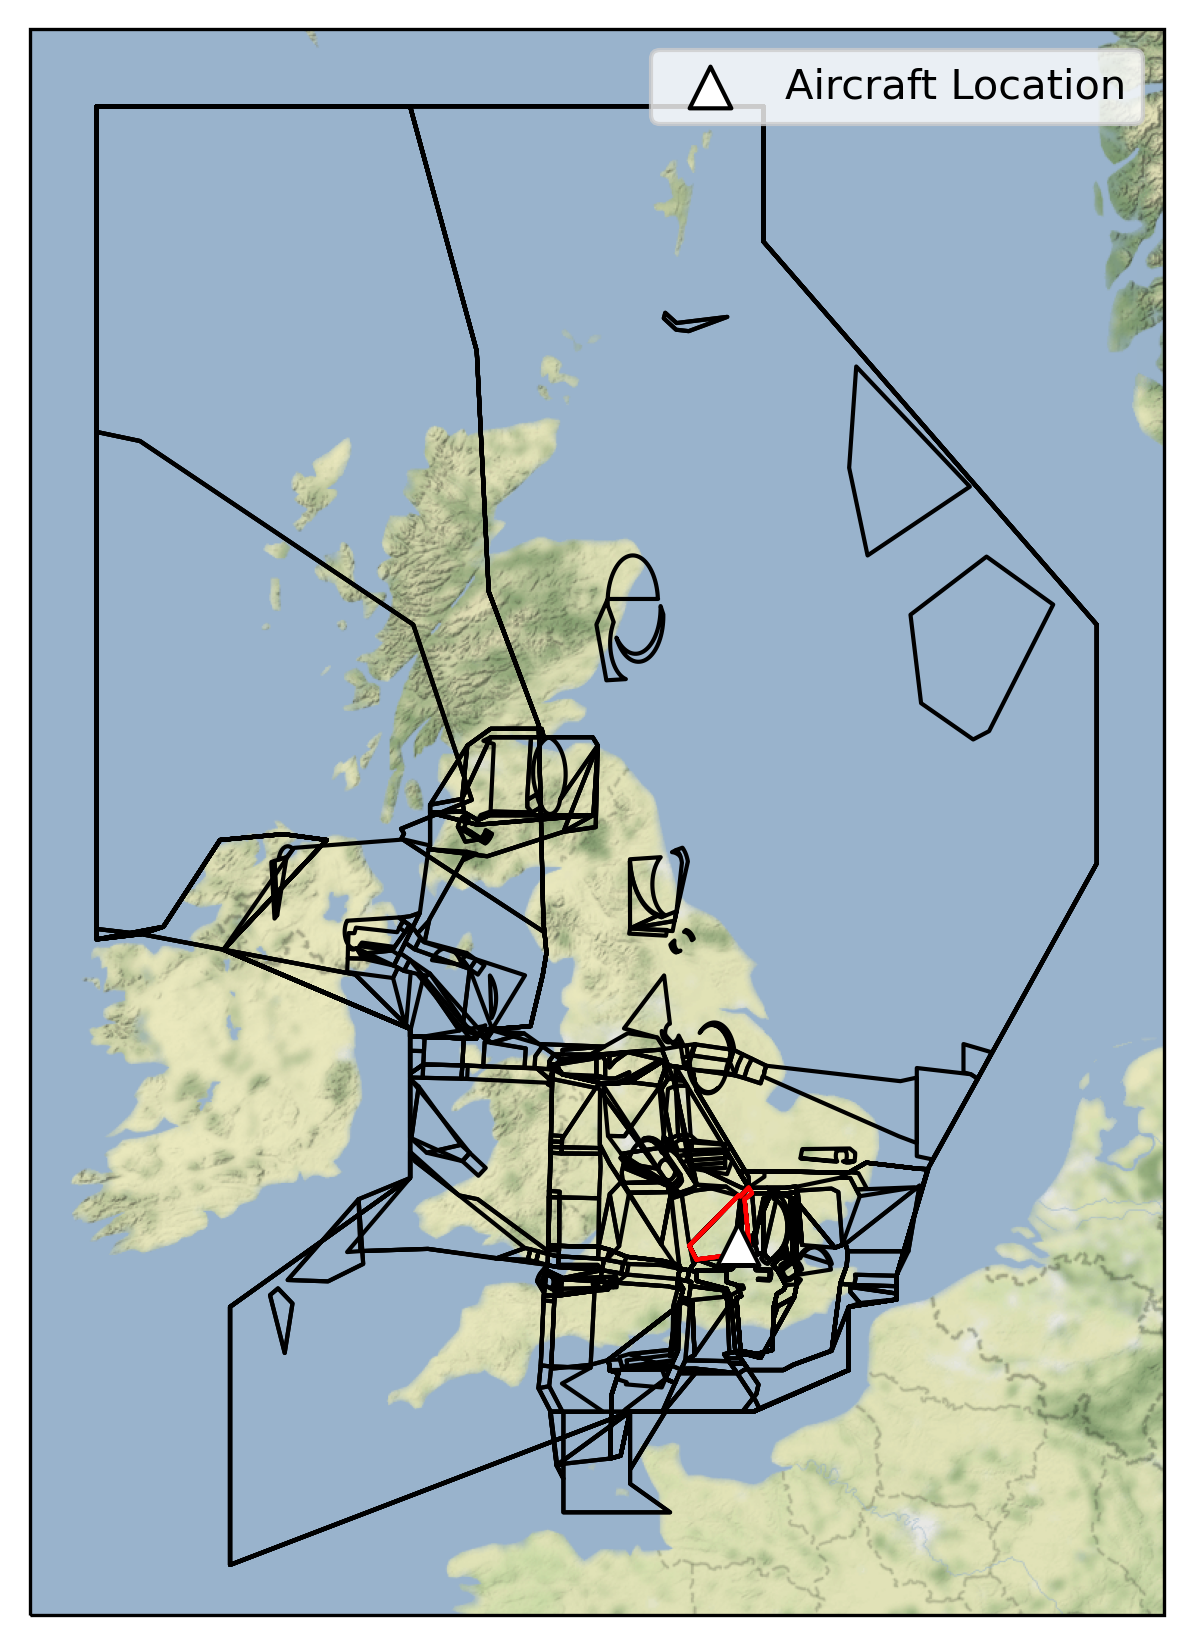

In [13]:
loc = Point(-0.388092, 51.590865)
v = 10000
gdf_filtered = gdf[(gdf.lower_limit < v) & (gdf.upper_limit > v) & gdf.geometry.contains(loc)]


fig = plt.figure(dpi=300, figsize=(7,7))

imagery = cimgt.Stamen(style="terrain-background")
ax = plt.axes(projection=imagery.crs)

minlon = -11
maxlon = 6
minlat = 48
maxlat = 61.5

ax.set_extent((minlon, maxlon, minlat, maxlat))
ax.add_image(imagery, 6)

ax.add_geometries(gdf.geometry, crs=ccrs.PlateCarree(), facecolor="none", edgecolor="black")

ax.add_geometries(gdf_filtered.geometry, crs=ccrs.PlateCarree(), facecolor="none", edgecolor="red")
ax.scatter(loc.x, loc.y, transform=ccrs.PlateCarree(), marker = "^", edgecolor="black", facecolor="white", s=100, zorder=10, label="Aircraft Location")

ax.legend(loc="upper right").set_zorder(100)
ax.set_aspect('auto')

plt.show()

## Export Data

We save the data to a file.

In [14]:
from flight_processing import DataConfig

In [15]:
config = DataConfig.known_dataset("uk")
out_location = config.dataset_location
out_location

'/mnt/cold_data/josh/processing/regions_uk_wkt.json'

In [16]:
gdf_out = gdf.copy()
del gdf_out['airspace']

gdf_out['wkt'] = gdf_out.geometry.apply(lambda g: g.wkt)
#del gdf_out['geometry']

gdf_out.to_file(config.dataset_location, driver="GeoJSON")

del gdf_out

ERROR:fiona._env:/mnt/cold_data/josh/processing/regions_uk_wkt.json: No such file or directory
